# Importing libraries and loading data

In [186]:
%pip install python-metar
%pip install geopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from geopy.distance import geodesic
from metar import Metar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from datetime import datetime, timedelta
from statistics import mode
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme()

In [188]:
bimtra_df = pd.read_csv('data/bimtra_df.csv')
esperas_df = pd.read_csv('data/esperas_df.csv')
metaf_df = pd.read_csv('data/metaf_df.csv')
metar_df = pd.read_csv('data/metar_df.csv')
tc_prev_df = pd.read_csv('data/tc-prev_df.csv')
tc_real_df = pd.read_csv('data/tc-real_df.csv')
test_data = pd.read_csv('data/idsc_test.csv')
cat_62 = pd.read_csv('data/cat-62_df.csv')

# Exploratory Analysis

In [189]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [190]:
test_data.snapshot_radar.sample(1)

58    MULTIPOINT ((-0.8937608353200434 -0.5234538462...
Name: snapshot_radar, dtype: object

In [191]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [192]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [193]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [194]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')
print(f'cat_62: {cat_62.shape}')

bimtra_df: (48821, 5)
esperas_df: (17856, 3)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)
cat_62: (6102640, 6)


# Pre Processing

In [195]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [196]:
bimtra_df['solution'].describe()

count    48821.000000
mean      4691.582372
std       2534.483202
min     -83541.000000
25%       2940.000000
50%       4112.000000
75%       5457.000000
max      19408.000000
Name: solution, dtype: float64

In [197]:
bimtra_df.sort_values(by='solution' ,ascending=True).head(5)

,flightid,origem,destino,dt_dep,dt_arr,solution
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541
1621,a8682cab7acc8720963b1bcf100e8e14,SBFL,SBSP,1654300317000,1654217151000,-83166
43358,8a053ceddd5cd22a111236b4975b990b,SBSP,SBCF,1658876193000,1658793794000,-82399
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133
43121,8bbeac6a115b8eed176d85126e5c4b98,SBBR,SBSP,1658876568000,1658795244000,-81324


In [198]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= 2000) & (bimtra_df['solution'] <= q3 + 1.5*iqr + 3000)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [199]:
bimtra_df['solution'].describe()

count    48502.000000
mean      4691.116201
std       2254.123029
min       2002.000000
25%       2945.000000
50%       4114.000000
75%       5444.000000
max      12223.000000
Name: solution, dtype: float64

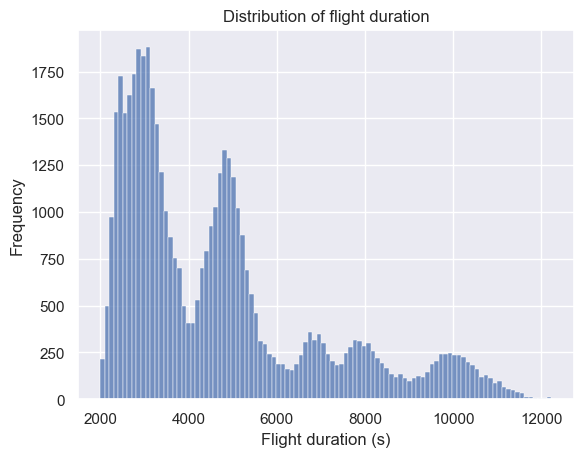

In [200]:
sns.histplot(bimtra_df['solution'], bins=100)
plt.title('Distribution of flight duration')
plt.xlabel('Flight duration (s)')
plt.ylabel('Frequency')
plt.show()

In [201]:
bimtra_df.query('solution < 0')

,flightid,origem,destino,dt_dep,dt_arr,solution


In [202]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [203]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00


In [204]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(6167, 4)

In [205]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [206]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [207]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (48502, 7)
esperas_df: (17856, 5)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)


In [208]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [209]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [210]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [211]:
train_data.sort_values(by='solution' ,ascending=False).head(20)

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
31817,c6ee21c9f340d972df91f762a3b92370,SBSV,SBPA,2022-07-08 17:57:27,2022-07-08 21:21:10,12223,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,NaN,NaN,NaN,NaT
9812,94cba9a52482732b50b18a3969828fec,SBSV,SBPA,2022-06-12 18:42:47,2022-06-12 22:06:26,12219,2022-06-12 18:00:00,0,SBPA,2022-06-12 18:00:00,1,SBPA,2022-06-12 18:00:00,NaN,NaN,NaN,NaT
51425,582f3a20fb7ebb2a741fa213973379b4,SBSV,SBPA,2022-07-29 17:57:46,2022-07-29 21:21:21,12215,2022-07-29 17:00:00,0,SBPA,2022-07-29 17:00:00,1,SBPA,2022-07-29 17:00:00,NaN,NaN,NaN,NaT
52209,02314e4281634ee3840ed7ef79b8f685,SBSV,SBPA,2022-07-30 18:06:32,2022-07-30 21:29:49,12197,2022-07-30 18:00:00,0,SBPA,2022-07-30 18:00:00,1,SBPA,2022-07-30 18:00:00,NaN,NaN,NaN,NaT
25169,72ec4a1e747c200085d7b78ce74d5448,SBSV,SBPA,2022-06-30 17:58:59,2022-06-30 21:22:14,12195,2022-06-30 17:00:00,0,SBPA,2022-06-30 17:00:00,1,SBPA,2022-06-30 17:00:00,29,11,SBPA,2022-06-30 17:17:00
49469,00d75cc32867fe9fc6520492b8224e4d,SBSV,SBPA,2022-07-27 18:12:22,2022-07-27 21:35:22,12180,2022-07-27 18:00:00,0,SBPA,2022-07-27 18:00:00,1,SBPA,2022-07-27 18:00:00,NaN,NaN,NaN,NaT
5959,a6e0a7165193a34dad4237e650af75ac,SBSV,SBPA,2022-06-08 18:02:31,2022-06-08 21:25:17,12166,2022-06-08 18:00:00,0,SBPA,2022-06-08 18:00:00,1,SBPA,2022-06-08 18:00:00,NaN,NaN,NaN,NaT
34154,d3a2974604fd4aac214ec3af25a9c9ab,SBRF,SBSP,2022-07-10 11:31:59,2022-07-10 14:54:41,12162,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,NaN,NaN,NaN,NaT
44520,fca3feeced4fd2f5f52aa83bef0369dd,SBRF,SBSP,2022-07-21 09:24:42,2022-07-21 12:47:14,12152,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,NaN,NaN,NaN,NaT
34160,6a652367d0fb5e46a983c8183aebdadb,SBRF,SBSP,2022-07-10 09:24:27,2022-07-10 12:46:51,12144,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,35L,17L,SBSP,2022-07-10 09:10:43


In [212]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
46847,316acb1b68dc901b8fdc8f4311dfdf98,SBGL,SBGR,2022-07-24 21:01:40,2022-07-24 21:47:53,2773,2022-07-24 21:00:00,0,SBGR,2022-07-24 21:00:00,0,SBGR,2022-07-24 21:00:00,NaN,NaN,NaN,NaT
19066,fa5eb11b04a2a26311e7a499a3d6346f,SBGL,SBBR,2022-06-23 09:22:30,2022-06-23 10:54:32,5522,2022-06-23 09:00:00,0,SBBR,2022-06-23 09:00:00,1,SBBR,2022-06-23 09:00:00,NaN,NaN,NaN,NaT
34866,670e5631a0cbdb55bc4daed701c13b36,SBRJ,SBCT,2022-07-11 15:38:04,2022-07-11 16:46:52,4128,2022-07-11 15:00:00,0,SBCT,2022-07-11 15:00:00,1,SBCT,2022-07-11 15:00:00,NaN,NaN,NaN,NaT
46216,f9072426c5c0a1a94f2c9ca0081d740d,SBGR,SBRF,2022-07-23 10:21:12,2022-07-23 12:57:43,9391,2022-07-23 10:00:00,0,SBRF,2022-07-23 10:00:00,0,SBRF,2022-07-23 10:00:00,NaN,NaN,NaN,NaT
27805,5e4a29eda4e6cd63ffb094129b751f54,SBSP,SBSV,2022-07-03 19:52:32,2022-07-03 21:49:03,6991,2022-07-03 19:00:00,0,SBSV,2022-07-03 19:00:00,1,SBSV,2022-07-03 19:00:00,17,10,SBSV,2022-07-03 19:21:03
10006,716956c0685553ff2d84345d650a0ca8,SBSP,SBRF,2022-06-12 16:00:02,2022-06-12 18:44:45,9883,2022-06-12 16:00:00,0,SBRF,2022-06-12 16:00:00,1,SBRF,2022-06-12 16:00:00,NaN,NaN,NaN,NaT
4553,274dbb67b593c30eb952258e8ac05b3c,SBCF,SBFL,2022-06-06 00:32:18,2022-06-06 02:15:12,6174,2022-06-06 00:00:00,0,SBFL,2022-06-06 00:00:00,0,SBFL,2022-06-06 00:00:00,NaN,NaN,NaN,NaT
12527,e896d9abcee12ace7ad91bb523515ed1,SBGL,SBGR,2022-06-15 18:58:13,2022-06-15 19:42:42,2669,2022-06-15 18:00:00,0,SBGR,2022-06-15 18:00:00,1,SBGR,2022-06-15 18:00:00,NaN,NaN,NaN,NaT
31612,c219e7a604cfdcd19cd66a6006ea790f,SBGR,SBSV,2022-07-07 21:05:37,2022-07-07 23:03:15,7058,2022-07-07 21:00:00,0,SBSV,2022-07-07 21:00:00,1,SBSV,2022-07-07 21:00:00,10,17,SBSV,2022-07-07 21:29:40
32036,c1970f23adc8f194374d3583cce85356,SBPA,SBSP,2022-07-08 12:56:34,2022-07-08 14:11:04,4470,2022-07-08 12:00:00,1,SBSP,2022-07-08 12:00:00,0,SBSP,2022-07-08 12:00:00,35L,02R,SBSP,2022-07-08 12:10:58


(54767, 17)

In [213]:
train_data.isna().sum() 

flightid                0
origem                  0
destino                 0
dt_dep                  0
dt_arr                  0
solution                0
hora_ref                0
esperas                 0
aero_esperas            0
hora_esperas            0
troca                   0
aero_tcp                0
hora_tcp                0
nova_cabeceira      37301
antiga_cabeceira    37301
aero_tcr            37301
hora_tcr            37301
dtype: int64

In [214]:
train_data.shape

(54767, 17)

In [215]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [216]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [217]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [218]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


## METAR and METAF decoding

In [219]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [220]:
test_data.metar = test_data.metar.apply(lambda x: x.replace('=', ''))

test_data['temperature_real'] = None
test_data['dew_point_real'] = None
test_data['wind_direction_real'] = None
test_data['visibility_real'] = None
test_data['wind_speed_real'] = None
test_data['pressure_real'] = None

for i, report in enumerate(test_data['metar']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_real'] = report.temp.value()
        test_data.at[i, 'dew_point_real'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_real'] = report.wind_dir.value()
        test_data.at[i, 'visibility_real'] = report.vis.value()
        test_data.at[i, 'wind_speed_real'] = report.wind_speed.value()
        test_data.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [221]:
test_data.metaf

0                                                   NaN
1     METAF SBRJ 190900Z  33004KT 9999       BKN033 ...
2       METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n
3     METAF SBSP 291700Z  15010KT 9999       OVC033 ...
4       METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n
5     METAF SBGR 241000Z 06005KT 3000     BR BKN033 ...
6      METAF SBKP 162000Z  18003KT CAVOK 23/08 Q1017=\n
7      METAF SBCT 270100Z  35004KT CAVOK 16/11 Q1019=\n
8     METAF SBSP 311600Z 06004KT 9999    RA  OVC023 ...
9                                                   NaN
10                                                  NaN
11      METAF SBBR 221500Z 08006KT CAVOK 23/07 Q1019=\n
12     METAF SBCF 170100Z  13006KT CAVOK 13/09 Q1017=\n
13    METAF SBRJ 311700Z  10009KT 9999  -TSRA  OVC02...
14    METAF SBRJ 311700Z  10009KT 9999  -TSRA  OVC02...
15    METAF SBSP 291500Z  14010KT 9999       OVC033 ...
16     METAF SBBR 191100Z  10005KT CAVOK 17/04 Q1019=\n
17    METAF SBSP 162100Z  17008KT 9999       BKN

In [222]:
test_data.metaf = test_data.metaf.fillna('')

In [223]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [224]:
metaf_df.shape

(5384, 3)

In [225]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [226]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [227]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
2342,2022-07-18 10:00:00,METAR SBGR 181000Z 11007KT 1000 BR OVC033...,SBGR,16.0,15.0,110.0,1000.0,7.0,1021.0
2306,2022-07-16 22:00:00,METAR SBGR 162200Z 33008KT CAVOK 20/10 Q1014,SBGR,20.0,10.0,330.0,10000.0,8.0,1014.0
839,2022-07-11 21:00:00,METAR SBGL 112100Z 15004KT CAVOK 26/17 Q1012,SBGL,26.0,17.0,150.0,10000.0,4.0,1012.0
4328,2022-06-18 14:00:00,METAR SBSP 181400Z 28002KT 6000 OVC029 ...,SBSP,18.0,15.0,280.0,6000.0,2.0,1018.0
4467,2022-06-24 09:00:00,METAR SBSP 240900Z 33005KT CAVOK 16/10 Q1015,SBSP,16.0,10.0,330.0,10000.0,5.0,1015.0


In [228]:
metaf_df.shape

(5384, 9)

In [229]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [230]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(18358, 18)

In [231]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [232]:
train_data.shape

(54767, 17)

In [233]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [234]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

## Label Encoding

In [235]:
le = LabelEncoder()

cat_columns = ['aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,aero_esperas,aero_tcp,aero_tcr
0,SBRJ,SBRJ,NaN
1,SBRJ,SBRJ,NaN
2,SBRJ,SBRJ,NaN
3,SBCF,SBCF,NaN
4,SBFL,SBFL,NaN


In [236]:
train_data[cat_columns].head()

,aero_esperas,aero_tcp,aero_tcr
0,9,9,12
1,9,9,12
2,9,9,12
3,1,1,12
4,3,3,12


## Feature Engineering

In [237]:
train_data['route_cat'], test_data['route_cat'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1), test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
le.fit(train_data['route_cat'])
train_data['route']= le.transform(train_data['route_cat'])
test_data['route']= le.transform(test_data['route_cat'])

display(train_data['route'].head())


0    51
1    46
2     8
3    16
4    13
Name: route, dtype: int64

In [238]:
train_data[['origem', 'destino']], test_data[['origem', 'destino']] = train_data[['origem', 'destino']].apply(le.fit_transform), test_data[['origem', 'destino']].apply(le.transform)

In [239]:
train_data['route'].unique()

array([51, 46,  8, 16, 13, 28, 19, 55, 44, 54, 49, 17,  5,  4,  0,  3, 35,
        7, 45, 58, 57,  9, 60, 20, 26, 47, 15, 59, 34, 61, 10, 18,  1, 37,
       33,  6, 38, 62, 25, 50, 21, 12, 53, 32, 31, 24,  2, 27, 22, 40, 56,
       42, 52, 14, 43, 39, 48, 41, 29, 11, 36, 30, 23])

In [240]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,...,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBKP-SBRJ,51
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBGR-SBRJ,46
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR-SBRJ,8
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBKP,16
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBFL,13


In [241]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,11,...,None,None,None,0,0,0,0,0,SBKP-SBSV,53
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,9,...,10000.0,4.0,1020.0,0,0,0,0,0,SBFL-SBRJ,34
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,5,...,10000.0,3.0,1021.0,0,0,0,0,0,SBCF-SBGR,15
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,10,...,10000.0,10.0,1019.0,0,0,0,0,0,SBFL-SBSP,35
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,6,...,10000.0,8.0,1019.0,0,0,0,0,0,SBCF-SBKP,16


In [242]:
np.count_nonzero(train_data.route.unique())

62

In [243]:
train_data['solution'].describe()

count    54767.000000
mean      4733.140303
std       2221.298059
min       2002.000000
25%       2987.000000
50%       4236.000000
75%       5653.500000
max      12223.000000
Name: solution, dtype: float64

In [244]:
train_data.shape

(54767, 35)

In [245]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [246]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [247]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)
test_data[columns_mean] = test_data[columns_mean].fillna(test_data[columns_mean].mean())

In [248]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [249]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [250]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54767 entries, 0 to 54766
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flightid             54767 non-null  object 
 1   origem               54767 non-null  int64  
 2   destino              54767 non-null  int64  
 3   dt_dep               54767 non-null  int32  
 4   solution             54767 non-null  int64  
 5   esperas              54767 non-null  int64  
 6   aero_esperas         54767 non-null  int64  
 7   troca                54767 non-null  int64  
 8   aero_tcp             54767 non-null  int64  
 9   aero_tcr             54767 non-null  int64  
 10  temperature_real     54767 non-null  float64
 11  dew_point_real       54767 non-null  float64
 12  wind_direction_real  54767 non-null  float64
 13  visibility_real      54767 non-null  float64
 14  wind_speed_real      54767 non-null  float64
 15  pressure_real        54767 non-null 

## Cat-62

### Distance

In [251]:
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# print("Lowest dt_radar for each flight:")
# print(lowest_lat_lon)

# print("\nHighest dt_radar for each flight:")
# print(highest_lat_lon)

In [252]:
# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid

result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')


# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()

,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-0.277090,-0.835903,-0.409024,-0.811327,14.842761
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-0.400255,-0.753191,-0.277745,-0.840381,16.664585
2,0003d070d3cddc8a27e29b0d7ec5d22e,-0.400288,-0.753024,-0.412329,-0.814326,6.952673
3,0004cef34a36fdefb955840edcd85920,-0.411467,-0.814176,-0.400477,-0.753041,6.912992
4,0006b847a46b199088d53b7e9b1d92b0,-0.225074,-0.667812,-0.408984,-0.811026,25.839791


In [253]:
import pandas as pd
from geopy.distance import geodesic
import math

# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Convert radians to degrees for latitudes and longitudes
lowest_lat_lon['lat'] = lowest_lat_lon['lat'].apply(lambda x: math.degrees(x))
lowest_lat_lon['lon'] = lowest_lat_lon['lon'].apply(lambda x: math.degrees(x))
highest_lat_lon['lat'] = highest_lat_lon['lat'].apply(lambda x: math.degrees(x))
highest_lat_lon['lon'] = highest_lat_lon['lon'].apply(lambda x: math.degrees(x))

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid
result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')

# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()


,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-15.876090,-47.893716,-23.435326,-46.485612,849.721124
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-22.932935,-43.154675,-15.913607,-48.150257,937.304044
2,0003d070d3cddc8a27e29b0d7ec5d22e,-22.934798,-43.145079,-23.624697,-46.657456,367.372408
3,0004cef34a36fdefb955840edcd85920,-23.575327,-46.648857,-22.945616,-43.146086,365.130565
4,0006b847a46b199088d53b7e9b1d92b0,-12.895815,-38.262813,-23.433042,-46.468382,1452.970535


In [254]:
display(result_df.shape)
display(train_data.shape)

(45911, 6)

(54767, 24)

In [255]:
result_df = result_df[result_df['distance'] > 0]

In [256]:
result_df['distance'].describe()

count    45885.000000
mean       825.193762
std        527.105003
min          0.005948
25%        371.940500
50%        676.519979
75%        961.140610
max       3371.121669
Name: distance, dtype: float64

### Speed

In [257]:
cat_62.head()

,flightid,lat,lon,flightlevel,speed,dt_radar
0,b6f0f8308bec35b30533f84c72dac496,-0.505849,-0.884547,80.0,122.0,1654976586000
1,b6f0f8308bec35b30533f84c72dac496,-0.511227,-0.885964,80.0,114.0,1654977185000
2,b6f0f8308bec35b30533f84c72dac496,-0.512399,-0.886286,80.0,122.0,1654977306000
3,b6f0f8308bec35b30533f84c72dac496,-0.514589,-0.886866,77.0,117.0,1654977544000
4,b6f0f8308bec35b30533f84c72dac496,-0.497432,-0.882033,80.0,117.0,1654975686000


In [258]:
speed_df = cat_62.groupby('flightid')['speed'].mean().reset_index()

In [259]:
speed_df.head()

,flightid,speed
0,000227eb6537e848e73cddb2e16c1cfa,374.767442
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,384.700000
2,0003d070d3cddc8a27e29b0d7ec5d22e,278.821782
3,0004cef34a36fdefb955840edcd85920,305.333333
4,0006b847a46b199088d53b7e9b1d92b0,361.530702


### Merging

In [260]:
train_data = pd.merge(train_data, result_df, on='flightid', how='inner')

In [261]:
train_data = pd.merge(train_data, speed_df, on='flightid', how='inner')

In [262]:
train_data.head(5)

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,...,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,speed
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,...,5.844191,1017.969148,SBKP-SBRJ,51,-23.049409,-47.089329,-22.918608,-43.162407,402.893743,363.492754
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,...,5.844191,1017.969148,SBGR-SBRJ,46,-23.408319,-46.407657,-22.912327,-43.161847,336.874290,324.048387
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,...,5.844191,1017.969148,SBBR-SBRJ,8,-15.878665,-47.894573,-22.913170,-43.160765,923.682989,395.265152
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,...,5.844191,1017.969148,SBCF-SBKP,16,-23.017542,-47.118901,-19.636025,-43.966203,497.097133,415.213333
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,...,5.844191,1017.969148,SBCF-SBFL,13,-19.654805,-43.948362,-27.674720,-48.532466,1003.534884,357.903030


In [263]:
train_data.shape

(51921, 30)

Text(0.5, 1.0, 'Distance Distribution')

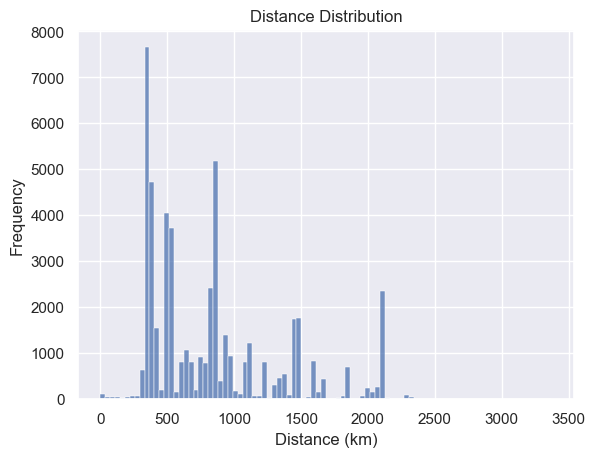

In [264]:
sns.histplot(train_data['distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distance Distribution')

In [265]:
train_data['median_distance'] = train_data.groupby('route')['distance'].transform('median')
route_median_mapping = train_data.set_index('route')['median_distance'].to_dict()
test_data['distance'] = test_data['route'].map(route_median_mapping)
train_data['distance'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,...,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,0,11,0,11,12,28.0,...,5.228261,1019.478261,0,0,0,0,0,SBKP-SBSV,53,1455.122485
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,0,9,0,9,12,19.0,...,4.000000,1020.000000,0,0,0,0,0,SBFL-SBRJ,34,755.358288
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,0,5,0,5,12,13.0,...,3.000000,1021.000000,0,0,0,0,0,SBCF-SBGR,15,490.689754
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2,10,0,10,12,19.0,...,10.000000,1019.000000,0,0,0,0,0,SBFL-SBSP,35,485.873175
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,0,6,0,6,12,23.0,...,8.000000,1019.000000,0,0,0,0,0,SBCF-SBKP,16,497.150203


In [266]:
train_data.head()

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,...,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,speed,median_distance
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,...,1017.969148,SBKP-SBRJ,51,-23.049409,-47.089329,-22.918608,-43.162407,408.105110,363.492754,408.105110
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,...,1017.969148,SBGR-SBRJ,46,-23.408319,-46.407657,-22.912327,-43.161847,344.342100,324.048387,344.342100
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,...,1017.969148,SBBR-SBRJ,8,-15.878665,-47.894573,-22.913170,-43.160765,923.832189,395.265152,923.832189
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,...,1017.969148,SBCF-SBKP,16,-23.017542,-47.118901,-19.636025,-43.966203,497.150203,415.213333,497.150203
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,...,1017.969148,SBCF-SBFL,13,-19.654805,-43.948362,-27.674720,-48.532466,1004.346329,357.903030,1004.346329


Text(0, 0.5, 'Frequency')

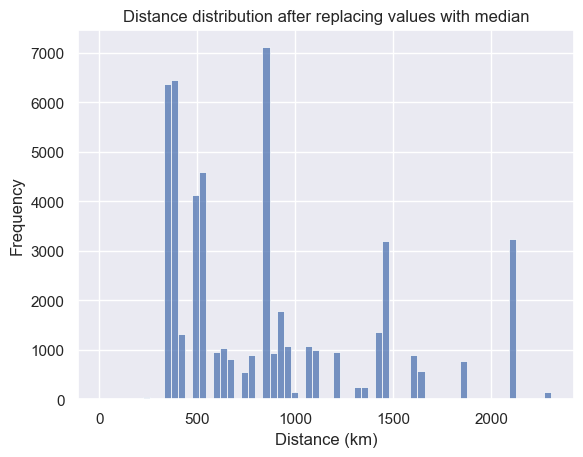

In [267]:
sns.histplot(train_data['distance'])
plt.title('Distance distribution after replacing values with median')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')

In [268]:
grouped_counts = train_data.groupby('route_cat')['distance'].value_counts().reset_index(name='count')

# Sort the DataFrame by 'distance'
sorted_counts = grouped_counts.sort_values(by=['distance', 'count'], ascending=[True, False])

print(sorted_counts)

    route_cat     distance  count
43  SBGR-SBGR     5.198789      6
48  SBKP-SBKP     5.768742      1
11  SBCF-SBCF    34.098083      4
41  SBGL-SBRJ    63.906649      1
52  SBKP-SBSP    77.920520      2
22  SBCT-SBFL   242.725257     41
28  SBCT-SBSP   330.655063   1673
37  SBGL-SBGR   337.796573    784
46  SBGR-SBRJ   344.342100   1308
25  SBCT-SBKP   347.722894    746
24  SBCT-SBGR   360.152975   1461
14  SBCF-SBGL   360.802126     27
33  SBFL-SBPA   362.306816    355
42  SBGL-SBSP   362.763435     24
60  SBRJ-SBSP   366.689719   4869
19  SBCF-SBRJ   370.685166   1170
38  SBGL-SBKP   400.162263    403
51  SBKP-SBRJ   408.105110   1327
35  SBFL-SBSP   485.873175   1586
15  SBCF-SBGR   490.689754   1502
16  SBCF-SBKP   497.150203   1030
31  SBFL-SBGR   514.043821   1123
20  SBCF-SBSP   521.476193   2193
26  SBCT-SBPA   531.479367    565
32  SBFL-SBKP   535.262651    716
0   SBBR-SBCF   589.961191    951
59  SBRF-SBSV   644.906248   1032
27  SBCT-SBRJ   676.642595    814
23  SBCT-SBGL 

In [269]:
routes_to_remove = ['SBGR-SBGR', 'SBKP-SBKP', 'SBCF-SBCF']

train_data = train_data[~train_data['route_cat'].isin(routes_to_remove)]

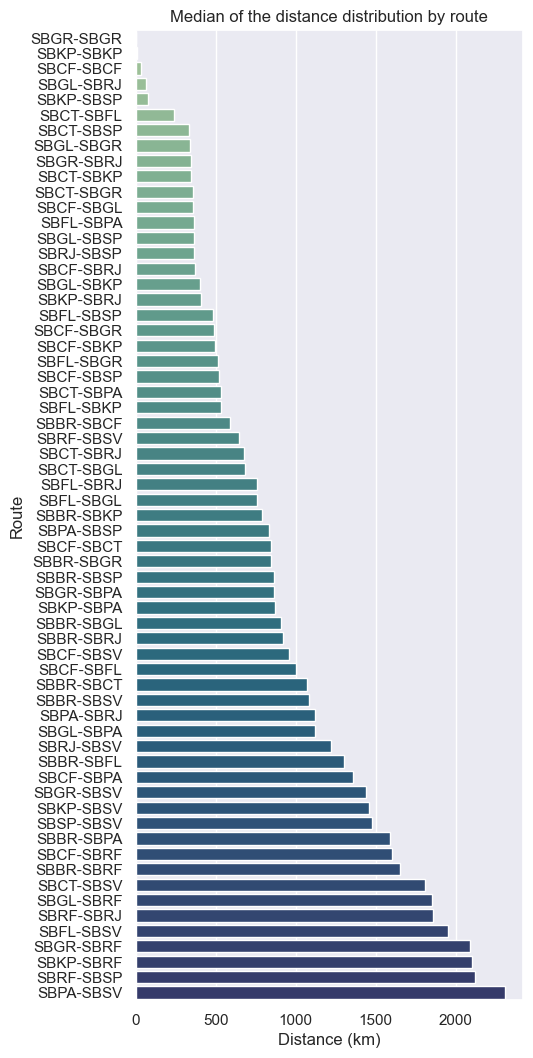

In [270]:
plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
sns.barplot(x='distance', y='route_cat', data=sorted_counts, palette='crest')
plt.ylabel('Route')
plt.xlabel('Distance (km)')
plt.title('Median of the distance distribution by route')
plt.show()

In [271]:
train_data['mean_speed'] = train_data.groupby('route')['speed'].transform('mean')
route_median_mapping = train_data.set_index('route')['mean_speed'].to_dict()
test_data['speed'] = test_data['route'].map(route_median_mapping)
train_data['speed'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,...,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance,speed
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,0,11,0,11,12,28.0,...,1019.478261,0,0,0,0,0,SBKP-SBSV,53,1455.122485,416.907654
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,0,9,0,9,12,19.0,...,1020.000000,0,0,0,0,0,SBFL-SBRJ,34,755.358288,356.639914
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,0,5,0,5,12,13.0,...,1021.000000,0,0,0,0,0,SBCF-SBGR,15,490.689754,354.528109
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2,10,0,10,12,19.0,...,1019.000000,0,0,0,0,0,SBFL-SBSP,35,485.873175,332.013453
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,0,6,0,6,12,23.0,...,1019.000000,0,0,0,0,0,SBCF-SBKP,16,497.150203,349.446888


In [272]:
# plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
# sns.barplot(x='mean_speed', y='route_cat', data=sorted_counts, palette='crest')
# plt.ylabel('Route')
# plt.xlabel('Speed (km/h)')
# plt.title('Median of the distance distribution by route')
# plt.show()

## Scaling

# Modeling

In [273]:
train_data.shape

(51910, 32)

In [274]:
features = train_data.columns
features = features.drop(['flightid', 'solution', 'start_lat', 'start_lon', 'final_lat', 'final_lon', 'median_distance', 'mean_speed','route_cat'])
# train_data[features] = scaler.fit_transform(train_data[features])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

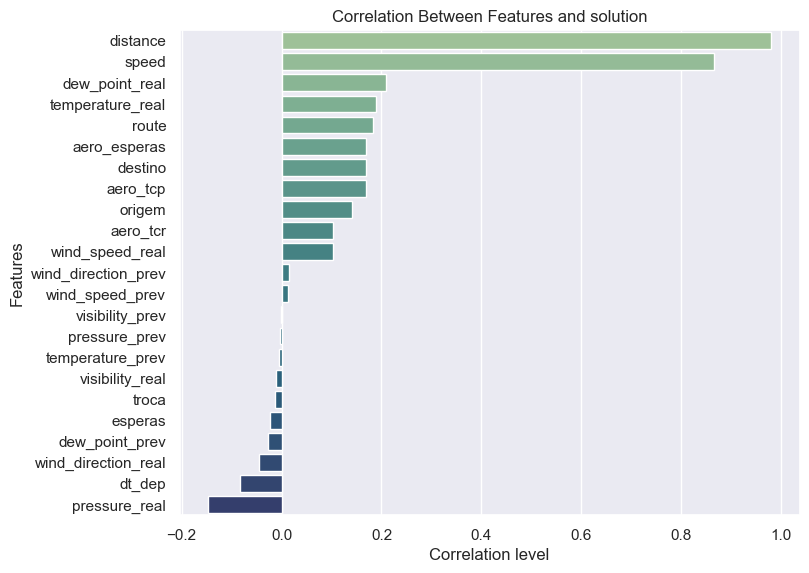

In [275]:

correlation = pd.DataFrame()
correlation['correlation'] = [train_data[column].corr(train_data['solution'], method='pearson') for column in features if train_data[column].corr(train_data['solution'], method='pearson') != 0]
correlation['features'] = [features for features in features if train_data[features].corr(train_data['solution'], method='pearson') != 0]

correlation = correlation.sort_values(by='correlation', ascending=False)
plt.figure(figsize=(8, .3*len(correlation.correlation.unique())))
plt.title('Correlation Between Features and solution')
sns.barplot(data=correlation, x='correlation', y='features', orient='h', palette='crest')
plt.xlabel('Correlation level')
plt.ylabel('Features')
plt.show()

In [276]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm

In [277]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')

# model2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# model2.fit(X_train, y_train)
# y_pred = model2.predict(X_test)
# y_pred = np.round_(y_pred)
# print(f'\nRandom Forest Regressor MSE: {mean_squared_error(y_test, y_pred)}')

model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)
print(f'\nXGBoost Regressor MSE: {mean_squared_error(y_test, y_pred)}')


XGBoost Regressor MSE: 77767.65661722212


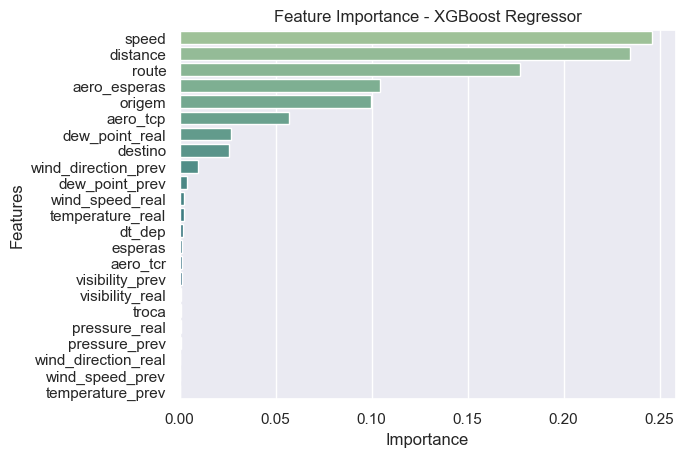

In [278]:
sns.barplot(data=pd.DataFrame({'features':features, 'importance':model3.feature_importances_}).sort_values(by='importance', ascending=False), x='importance', y='features', orient='h', palette='crest')
plt.title('Feature Importance - XGBoost Regressor')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

In [279]:
train_data['solution'].sort_values(ascending=True).head(10)

2218     2002
15790    2002
2219     2002
12463    2005
15689    2005
41064    2005
50257    2005
18438    2006
30204    2008
46588    2008
Name: solution, dtype: int64

# Submission

In [280]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

output.to_csv('data/submission.csv', index=False)